In [1]:
import numpy as np
import mne
import os, glob
import matplotlib.pyplot as plt

mne.viz.set_browser_backend("matplotlib")

Using matplotlib as 2D backend.


### Set Parameters

In [2]:
# set parameters
SUBJECT = "C"
SESSION = "Moth2"
BLOCKS = ["01", "02", "03", "04", "05", "06", "07", "08"] if SESSION == "Moth1" or SESSION == "Moth4" else ["01", "02", "03", "04", "05", "06", "07"]
LOC_RAW = f"/project_data/volume0/newmeg/{SESSION}/data/raw/{SUBJECT}/"
LOC_ROOT = f"/project_data/volume0/jerryjin/moth_meg/{SESSION}/"
LOC_SSS = LOC_ROOT + f"sss/{SUBJECT}/"
# LOC_SSS = f"/project_data/volume0/jerryjin/moth_meg/{SESSION}/mysss/{SUBJECT}/"
PLOT = True

In [3]:
ER_NWINS = 4
ER_WINLEN = 10
ER_NGRAD = 2
ER_NMAG = 2
FILT_LFREQ = None
FILT_HFREQ = 150
NOTCH_FREQS = [60, 120]
ECG_METHOD = "ica"  # "self" or "first" or "ica" or None
EOG_METHOD = "ica"  # "self" or "first" or "ica" or None

In [4]:
# file slug
slug = ""
slug += f"_er-{ER_NWINS}-{ER_WINLEN}-{ER_NGRAD}-{ER_NMAG}"
if FILT_LFREQ is not None and FILT_HFREQ is not None:
    slug += f"_band-{FILT_LFREQ}-{FILT_HFREQ}"
elif FILT_LFREQ is not None:
    slug += f"_highpass-{FILT_LFREQ}"
elif FILT_HFREQ is not None:
    slug += f"_lowpass-{FILT_HFREQ}"
if NOTCH_FREQS is not None:
    slug += f"_notch-{"-".join(map(str, NOTCH_FREQS))}"
if ECG_METHOD is not None:
    slug += f"_ecg-{ECG_METHOD}"
if EOG_METHOD is not None:
    slug += f"_eog-{EOG_METHOD}"
slug

'_er-4-10-2-2_lowpass-150_notch-60-120_ecg-ica_eog-ica'

In [5]:
dir_name = "sss" + slug
LOC_SAVE = LOC_ROOT + f"{dir_name}/{SUBJECT}/"
# if ECG_METHOD == "ica" and EOG_METHOD == "ica":
#     LOC_SAVE = f"/project_data/volume0/jerryjin/moth_meg/{SESSION}/mysss_myafter_ica/{SUBJECT}/"
# make save directory if it doesn't exist
if not os.path.exists(LOC_SAVE):
    os.makedirs(LOC_SAVE)

### Check Files

In [6]:
files = sorted(glob.glob(LOC_SSS + "*.fif"))
files

['/project_data/volume0/jerryjin/moth_meg/Moth2/sss/C/C_Moth2_01_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth2/sss/C/C_Moth2_02_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth2/sss/C/C_Moth2_03_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth2/sss/C/C_Moth2_04_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth2/sss/C/C_Moth2_05_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth2/sss/C/C_Moth2_06_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth2/sss/C/C_Moth2_07_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth2/sss/C/C_Moth2_EmptyRoom_sss_raw.fif']

In [7]:
# load first recording
if ECG_METHOD == "first" or EOG_METHOD == "first":
    first_f = glob.glob(LOC_SSS + f"*{SUBJECT}_{SESSION}_01*raw.fif")[0]
    first_sss = mne.io.read_raw_fif(first_f)

### Run Preprocess

In [8]:
# load empty room
er_f = glob.glob(LOC_SSS + f"*{SUBJECT}_{SESSION}_EmptyRoom*raw.fif")[0]
er_sss = mne.io.read_raw_fif(er_f, preload=True)

# determine intervals
n_windows = ER_NWINS
window_len = ER_WINLEN
er_len = er_sss[0][0].shape[1]
center_dist = np.floor(er_len / (1.0 + n_windows))
curr_center = center_dist
starts = []
stops = []
for i in range(n_windows):
    half_win_len = np.floor(er_sss.info["sfreq"] * window_len * 0.5)
    (win_start, win_stop) = (curr_center - half_win_len, curr_center + half_win_len)
    win_start = er_sss.times[int(win_start)]
    win_stop = er_sss.times[int(win_stop)]
    curr_center += center_dist
    starts.append(win_start)
    stops.append(win_stop)

# calculate emptyroom projs
er_projs = []
for start, stop in zip(starts, stops):
    er_projs.extend(mne.compute_proj_raw(er_sss, start=start, stop=stop, n_grad=ER_NGRAD, n_mag=ER_NMAG, verbose=True))

Opening raw data file /project_data/volume0/jerryjin/moth_meg/Moth2/sss/C/C_Moth2_EmptyRoom_sss_raw.fif...
    Range : 40000 ... 364999 =     40.000 ...   364.999 secs
Ready.
Reading 0 ... 324999  =      0.000 ...   324.999 secs...
Not setting metadata
10 matching events found
No baseline correction applied
Dropped 0/10 epochs
Adding projection: planar-Raw-60.000-70.000-PCA-01 (exp var=11.3%)
Adding projection: planar-Raw-60.000-70.000-PCA-02 (exp var=7.3%)
Adding projection: axial-Raw-60.000-70.000-PCA-01 (exp var=21.3%)
Adding projection: axial-Raw-60.000-70.000-PCA-02 (exp var=12.5%)
No channels 'eeg' found. Skipping.
Not setting metadata
10 matching events found
No baseline correction applied
Dropped 0/10 epochs
Adding projection: planar-Raw-125.000-135.000-PCA-01 (exp var=11.0%)
Adding projection: planar-Raw-125.000-135.000-PCA-02 (exp var=8.9%)
Adding projection: axial-Raw-125.000-135.000-PCA-01 (exp var=22.5%)
Adding projection: axial-Raw-125.000-135.000-PCA-02 (exp var=13.4%)
N

In [9]:
# define bandpass filter parameters
l_trans_bandwidth = 0.5 if FILT_LFREQ is not None and FILT_LFREQ > 0.5 else "auto"
h_trans_bandwidth = 0.5 if FILT_HFREQ is not None and FILT_HFREQ > 0.5 else "auto"
bandpass_params = dict(
    l_freq=FILT_LFREQ,
    h_freq=FILT_HFREQ,
    filter_length="10s",
    l_trans_bandwidth=l_trans_bandwidth,
    h_trans_bandwidth=h_trans_bandwidth,
    phase="zero-double",
    fir_window="hann",
    fir_design="firwin2",
)

In [10]:
# define notch filter parameters
notch_params = dict(
    freqs=NOTCH_FREQS,
    filter_length="10s",
    phase="zero-double",
    fir_window="hann",
    fir_design="firwin2",
)

Opening raw data file /project_data/volume0/jerryjin/moth_meg/Moth2/sss/C/C_Moth2_01_sss_raw.fif...


    Range : 53000 ... 706999 =     53.000 ...   706.999 secs
Ready.
Reading 0 ... 653999  =      0.000 ...   653.999 secs...
>>Now applying empty room correction...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
>>Now applying bandpass filtering...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal lowpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 150.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    6.9s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   12.8s


>>Now applying notch filtering...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.5s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.2s


>>Now removing heartbeat artifacts...
Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 79.8s.
Using threshold: 0.16 for CTPS ECG detection
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 739 (average pulse 67.79816513761467 / min.)
Not setting metadata
739 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 13)
Using data from preloaded Raw for 739 e

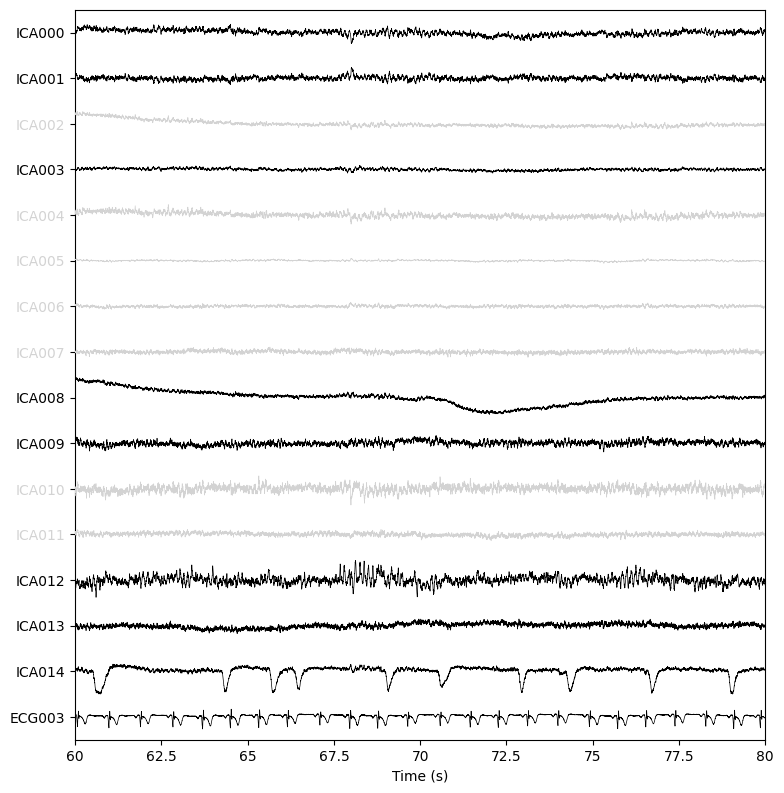

Creating RawArray with float64 data, n_channels=16, n_times=654000
    Range : 53000 ... 706999 =     53.000 ...   706.999 secs
Ready.


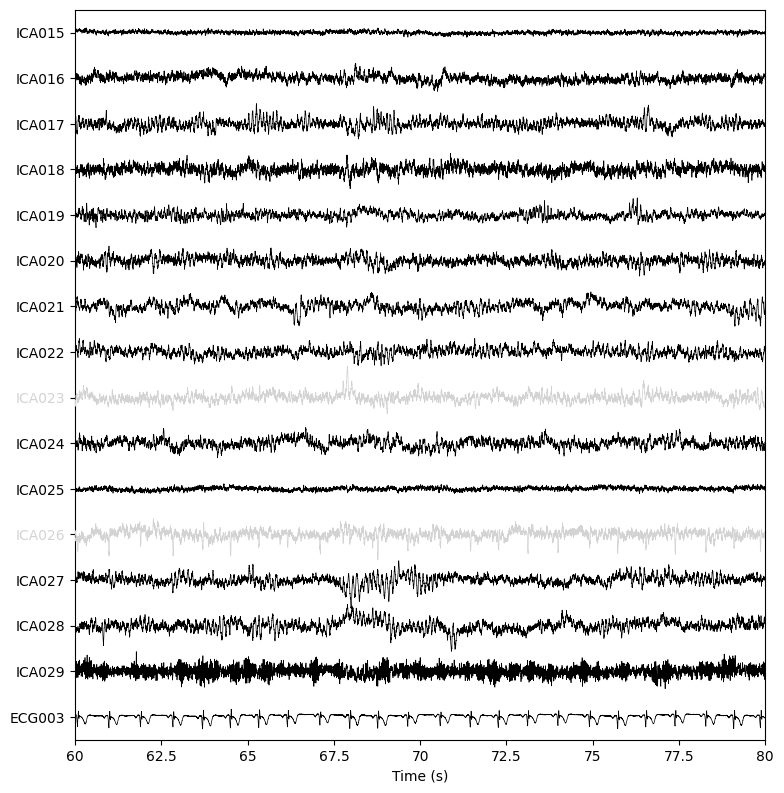

NameError: name 'eog_indices' is not defined

In [ ]:
all_raw_sss = []
for BLOCK in BLOCKS:

    # load raw data
    sss_f = glob.glob(LOC_SSS + f"*{SUBJECT}_{SESSION}_{BLOCK}*raw.fif")[0]
    raw_sss = mne.io.read_raw_fif(sss_f, preload=True)

    # empty room correction
    print(">>Now applying empty room correction...")
    raw_sss.add_proj(er_projs)
    raw_sss.apply_proj()

    # bandpass filtering
    print(">>Now applying bandpass filtering...")
    raw_sss.filter(**bandpass_params)

    # notch filtering
    print(">>Now applying notch filtering...")
    raw_sss.notch_filter(**notch_params)

    # heartbeat removal
    if ECG_METHOD is not None:

        print(">>Now removing heartbeat artifacts...")

        if ECG_METHOD == "first":
            # do all the steps for first recording
            first_sss_sub = first_sss.copy().load_data()
            first_sss_sub.add_proj(er_projs)
            first_sss_sub.apply_proj()
            first_sss_sub.filter(**bandpass_params, verbose=False)
            first_sss_sub.notch_filter(**notch_params, verbose=False)
            # compute ecg projs
            ecg_projs, _ = mne.preprocessing.compute_proj_ecg(first_sss_sub, average=False)
            # save memory
            del first_sss_sub
            # apply ecg projs
            raw_sss.add_proj(ecg_projs)
            raw_sss.apply_proj()

        elif ECG_METHOD == "self":
            # compute ecg projs
            ecg_projs, _ = mne.preprocessing.compute_proj_ecg(raw_sss, average=False)
            # apply ecg projs
            raw_sss.add_proj(ecg_projs)
            raw_sss.apply_proj()

        elif ECG_METHOD == "ica":
            # load raw data and filter (high-pass filter necessary for ica)
            raw_f = glob.glob(LOC_RAW + f"*{SUBJECT}_{SESSION}_{BLOCK}*raw.fif")[0]
            raw_ica = mne.io.read_raw_fif(raw_f, preload=True, verbose=False).pick(["meg", "ecg"]).filter(**bandpass_params, verbose=False)
            # fit ICA
            ica_ecg = mne.preprocessing.ICA(n_components=30, random_state=42)
            ica_ecg.fit(raw_ica)
            # find ecg components
            ecg_indices, ecg_scores = ica_ecg.find_bads_ecg(raw_ica, l_freq=5, h_freq=35)
            # in case that ECG channel is bad, we get rid of it
            # if len(ecg_indices) == 0:
            #     raw_ica = raw_ica.pick(["meg"])
            #     ecg_indices, ecg_scores = ica_ecg.find_bads_ecg(raw_ica, l_freq=5, h_freq=35)
            ica_ecg.exclude = ecg_indices
            print(f"Detect {len(ecg_indices)} ECG components.")
            # plot ica components
            if PLOT:
                ica_ecg.plot_sources(raw_ica, start=60, stop=80, show_scrollbars=False, picks=np.arange(15))
                ica_ecg.plot_sources(raw_ica, start=60, stop=80, show_scrollbars=False, picks=np.arange(15, 30))
            # check
            assert len(eog_indices) < 8  # C-Moth2-01 fails
            # apply ICA
            ica_ecg.apply(raw_sss)
            # save memory
            del raw_ica

        else:
            raise ValueError("ECG_METHOD not recognized.")

    # eyeblink removal
    if EOG_METHOD is not None:

        print(">>Now removing eyeblink artifacts...")

        if EOG_METHOD == "first":
            # do all the steps for first recording
            first_sss_sub = first_sss.copy().load_data()
            first_sss_sub.add_proj(er_projs)
            first_sss_sub.apply_proj()
            first_sss_sub.filter(**bandpass_params, verbose=False)
            first_sss_sub.notch_filter(**notch_params, verbose=False)
            ecg_projs, _ = mne.preprocessing.compute_proj_ecg(first_sss_sub, average=False)
            first_sss_sub.add_proj(ecg_projs)
            first_sss_sub.apply_proj()
            # compute eog projs
            eog_projs, _ = mne.preprocessing.compute_proj_eog(first_sss_sub, average=False)
            # save memory
            del first_sss_sub
            # apply eog projs
            raw_sss.add_proj(eog_projs)
            raw_sss.apply_proj()

        elif EOG_METHOD == "self":
            # compute eog projs
            eog_projs, _ = mne.preprocessing.compute_proj_eog(raw_sss, average=False)
            # apply eog projs
            raw_sss.add_proj(eog_projs)
            raw_sss.apply_proj()

        elif EOG_METHOD == "ica":
            # load filtered data with only MEG channels
            raw_sss_ica = raw_sss.copy().pick(["meg", "eog"])
            # fit ICA
            ica_eog = mne.preprocessing.ICA(n_components=30, random_state=42)
            ica_eog.fit(raw_sss_ica)
            # find eog components
            ref_channel = "EOG002" if "EOG002" in raw_sss_ica.ch_names else "MEG1213"
            if SUBJECT == "C" and SESSION == "Moth2":  # special case where EOG signal is flat
                ref_channel = "MEG1213"
            eog_indices, eog_scores = ica_eog.find_bads_eog(raw_sss_ica, ch_name=ref_channel)
            ica_eog.exclude = eog_indices
            print(f"Detect {len(eog_indices)} EOG components.")
            # plot ica components
            if PLOT:
                ica_eog.plot_sources(raw_sss, start=60, stop=80, show_scrollbars=False, picks=np.arange(15))
                ica_eog.plot_sources(raw_sss, start=60, stop=80, show_scrollbars=False, picks=np.arange(15, 30))
            # check
            assert len(eog_indices) < 5
            # apply ICA
            ica_eog.apply(raw_sss)
            # save memory
            del raw_sss_ica

        else:
            raise ValueError("EOG_METHOD not recognized.")

    # save
    # save_f = os.path.basename(sss_f).replace("_raw.fif", f"{slug}_raw.fif")
    # raw_sss.save(LOC_SAVE + save_f)

    # append to list for plotting
    all_raw_sss.append(raw_sss)

### Plot

Effective window size : 2.048 (s)
Plotting power spectral density (dB=False).


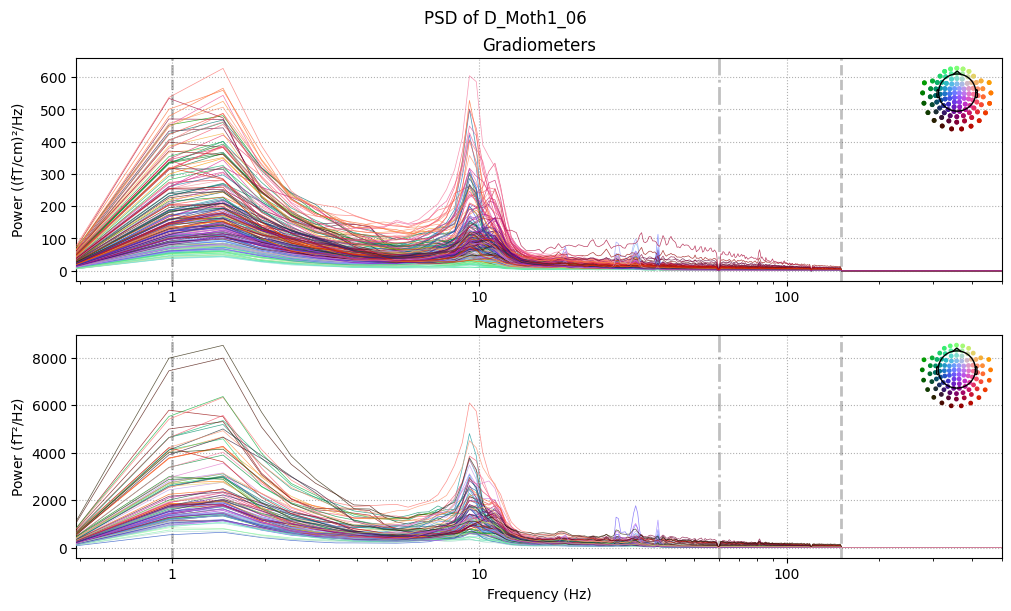

In [ ]:
average = False
if PLOT:
    for raw_sss, BLOCK in zip(all_raw_sss, BLOCKS):
        spectrum = raw_sss.compute_psd()
        spectrum.plot(average=average, dB=False, xscale="log")
        plt.suptitle(f"PSD of {SUBJECT}_{SESSION}_{BLOCK}")
        plt.show()